In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader, TensorDataset, Subset


import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.fftpack import fft
import numpy as np
from sklearn.model_selection import KFold


class CNN_RNN_Model(nn.Module):
    def __init__(self, time_steps, n_frequencies, hidden_size=64, num_layers=2):
        super(CNN_RNN_Model, self).__init__()

        # Convolutional layers for cleaned and raw time series data
        self.conv1 = nn.Conv2d(
            in_channels=2, out_channels=32, kernel_size=(5, 3), stride=(1, 1)
        )
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(3, 5), stride=(1, 1)
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
        )
        self.conv4 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1)
        )
        self.conv5 = nn.Conv2d(
            in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1)
        )
        self.dropout = nn.Dropout(p=0.5)

        # Calculate the output dimensions after convolution and pooling
        dummy_input = torch.zeros(1, 2, time_steps, n_frequencies)
        conv_output_shape = self._get_conv_output(dummy_input)

        # Bidirectional LSTM for sequential learning
        self.lstm = nn.LSTM(
            input_size=conv_output_shape[2],
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=True,
        )

        # Convolutional layers for PSD data
        self.conv_psd1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv_psd2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool_psd = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv_psd3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv_psd4 = nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )

        # Calculate the output dimensions after convolution and pooling for PSD data
        dummy_psd_input = torch.zeros(1, 1, time_steps, n_frequencies)
        psd_output_shape = self._get_psd_conv_output(dummy_psd_input)

        # Fully connected layers for final prediction
        self.fc1 = nn.Linear(
            hidden_size * 2  # Multiply by 2 for bidirectional LSTM
            + psd_output_shape[1] * psd_output_shape[2] * psd_output_shape[3],
            256,
        )
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, n_frequencies)

    def _get_conv_output(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        return x.view(
            x.size(0), x.size(2), -1
        ).shape  # Output as (batch, time_steps, features)

    def _get_psd_conv_output(self, x):
        x = self.pool_psd(F.relu(self.conv_psd1(x)))
        x = self.pool_psd(F.relu(self.conv_psd2(x)))
        x = F.relu(self.conv_psd3(x))
        x = self.pool_psd(F.relu(self.conv_psd4(x)))
        return x.shape  # Output shape

    def forward(self, x_clean, x_raw, x_psd):
        # Combine cleaned and raw time series data as two channels
        x_combined = torch.stack((x_clean, x_raw), dim=1)

        # Apply convolutional layers to combined time series data
        x_combined = self.pool(F.relu(self.conv1(x_combined)))
        x_combined = self.pool(F.relu(self.conv2(x_combined)))
        x_combined = F.relu(self.conv3(x_combined))
        x_combined = self.pool(F.relu(self.conv4(x_combined)))
        x_combined = F.relu(self.conv5(x_combined))
        x_combined = self.dropout(x_combined)

        # Reshape for LSTM input
        x_combined = x_combined.view(
            x_combined.size(0), x_combined.size(2), -1
        )  # (batch_size, new_time_steps, new_features)

        # Bidirectional LSTM layer
        x_combined, _ = self.lstm(x_combined)

        # Use the output of the last LSTM time step
        x_combined = x_combined[:, -1, :]

        # Apply convolutional layers to PSD data
        x_psd = x_psd.unsqueeze(1)  # Add a channel dimension
        x_psd = self.pool_psd(F.relu(self.conv_psd1(x_psd)))
        x_psd = self.pool_psd(F.relu(self.conv_psd2(x_psd)))
        x_psd = F.relu(self.conv_psd3(x_psd))
        x_psd = self.pool_psd(F.relu(self.conv_psd4(x_psd)))
        x_psd = x_psd.view(x_psd.size(0), -1)  # Flatten
        x_psd = self.dropout(x_psd)

        # Concatenate features from both branches
        x = torch.cat((x_combined, x_psd), dim=1)

        # Fully connected layers for final prediction
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


# Load the best model
model = CNN_RNN_Model(time_steps=187, n_frequencies=282)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # Set the model to evaluation mode

Using device: cuda


/tmp/ipykernel_4358/122872139.py:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


CNN_RNN_Model(
  (conv1): Conv2d(2, 32, kernel_size=(5, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(15360, 64, num_layers=2, batch_first=True, bidirectional=True)
  (conv_psd1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_psd2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_psd): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_psd3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_psd4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=206208,

In [15]:
def compute_spectral_density(signal):
    # Perform the Fast Fourier Transform (FFT)
    fft_values = np.fft.fft(signal)

    # Calculate the Power Spectral Density
    psd = np.abs(fft_values) ** 2 / len(signal)

    return psd


def load_npy_in_batches(file_path, batch_size):
    data = np.load(file_path, mmap_mode='r')
    total_samples = data.shape[0]

    for start_idx in range(0, total_samples, batch_size):
        end_idx = min(start_idx + batch_size, total_samples)
        yield data[start_idx:end_idx]


def prepare_submission(nn_pred, wc_ratio):
    nn_pred = nn_pred / 1000
    nn_pred.clip(0)
    nn_pred = np.nan_to_num(nn_pred, nan=0.0)
    nn_pred += wc_ratio
    nn_pred = nn_pred[:, ::-1]
    return nn_pred

In [46]:
# Example usage
batch_size = 32
fitted_lc_batches = load_npy_in_batches(
    "../outputs/results/basic_fit/lc_curves.npy", batch_size)
airs_batches = load_npy_in_batches(
    "../data/processed/kaggle_sub_processed/airs_v4.npy", batch_size)


predictions = []
# Process each batch
for lc_batch, airs_batch in zip(fitted_lc_batches, airs_batches):

    airs_batch = airs_batch.sum(axis=3)
    # Normalize the data
    normalized_lc = lc_batch / lc_batch[:, :10, :].mean(axis=1, keepdims=True)
    normalized_airs = airs_batch / \
        airs_batch[:, :10].mean(axis=1, keepdims=True)

    mean_lc = normalized_lc.mean(axis=1, keepdims=True)
    demeaned_lc = normalized_lc - mean_lc

    psd_lc = compute_spectral_density(demeaned_lc)

    normalized_psd_lc = psd_lc / \
        np.percentile(psd_lc, 95, axis=1, keepdims=True)

    # Convert to torch tensors
    example_clean = torch.from_numpy(normalized_lc).float()
    example_raw = torch.from_numpy(normalized_airs).float()
    example_psd = torch.from_numpy(normalized_psd_lc).float()

    # Create DataLoader
    dataset = TensorDataset(example_clean, example_raw, example_psd)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process each batch with the model
    with torch.no_grad():
        for x_clean, x_raw, x_psd in dataloader:
            outputs = model(x_clean.to(device), x_raw.to(
                device), x_psd.to(device))
            predictions.append(outputs.cpu().numpy())

# Concatenate all predictions
predictions = np.concatenate(predictions, axis=0)
print(predictions.shape)  # Should match the input data shape

(673, 282)


In [64]:
sigmas[0]

array([0.00027335, 0.00036664, 0.00038254, 0.00039222, 0.00039169,
       0.000411  , 0.00041031, 0.00038859, 0.00039173, 0.0004038 ,
       0.00040558, 0.00040301, 0.00039587, 0.00038085, 0.00038505,
       0.00039112, 0.00037968, 0.00036996, 0.00036024, 0.0003473 ,
       0.00032929, 0.00031593, 0.00030182, 0.00029304, 0.00028027,
       0.00026699, 0.00025841, 0.00024486, 0.00023658, 0.00020876,
       0.0001919 , 0.00018379, 0.00020066, 0.00019439, 0.00019406,
       0.00018902, 0.0001858 , 0.00019112, 0.0001912 , 0.0001871 ,
       0.00019112, 0.00019256, 0.00018592, 0.00018158, 0.00017773,
       0.0001858 , 0.00018999, 0.00020218, 0.00020233, 0.0001933 ,
       0.00019511, 0.00020177, 0.00018706, 0.00018256, 0.0001743 ,
       0.0001778 , 0.00017619, 0.00018449, 0.00017256, 0.00017324,
       0.00017869, 0.00017946, 0.00018519, 0.00019341, 0.0001962 ,
       0.00019771, 0.00019954, 0.00021014, 0.00022241, 0.00022531,
       0.00022787, 0.00023064, 0.00023571, 0.00024061, 0.00024

In [47]:
wc_ratio = np.load("../outputs/results/basic_fit/wc_ratio.npy")
lc_ratio = np.load("../outputs/results/basic_fit/lc_ratio.npy")

In [17]:
new_predictions = prepare_submission(predictions, wc_ratio)

In [59]:
lc_ratio.shape

(673, 282)

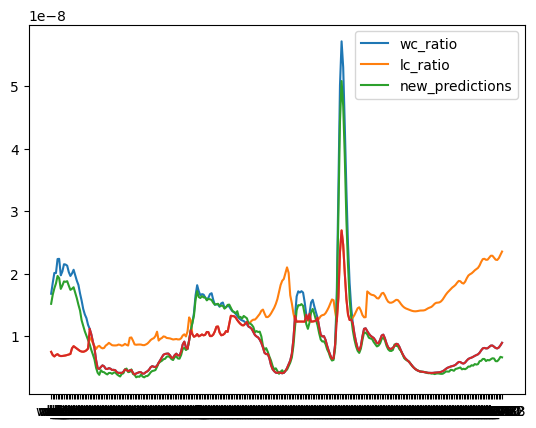

In [60]:

nn_error_array = ((new_predictions - gt.iloc[:, 2:]) ** 2).mean(axis=0)
lc_error_array = ((lc_ratio[:, ::-1] - gt.iloc[:, 2:]) ** 2).mean(axis=0)
mask = nn_error_array > lc_error_array

combined_ratio = wc_ratio.copy()
combined_ratio[:, mask] = lc_ratio[:, ::-1][:, mask]


plt.plot(((wc_ratio - gt.iloc[:, 2:]) ** 2).mean(axis=0), label='wc_ratio')
plt.plot(((lc_ratio[:, ::-1] - gt.iloc[:, 2:])
         ** 2).mean(axis=0), label='lc_ratio')
plt.plot(((new_predictions - gt.iloc[:, 2:])
         ** 2).mean(axis=0), label='new_predictions')
plt.plot(((combined_ratio - gt.iloc[:, 2:]) ** 2).mean(axis=0))
# plt.plot(combined_array)
plt.legend()

In [21]:
gt = pd.read_csv("../data/raw/train_labels.csv")

In [35]:
import sys

sys.path.append("../")
sys.path.append("../scripts")

In [62]:
from metrics import simple_score, score

sample_sub = pd.read_csv("../data/raw/sample_submission.csv")

# Find the best scaling value for sigma
best_score = 0
best_scale = 0
naive_mean = np.mean(gt.values[:, 1:])
naive_sigma = np.std(gt.values[:, 1:])
best_sigma = None

for i in np.arange(1, 3, 0.01):
    preds = new_predictions.copy()
    # preds = combined_ratio.copy()

    constant_value = np.full((preds.shape[0], 1), preds.mean().mean())
    # print(preds.shape)

    sigmas = np.vstack(
        [np.std((preds - gt.iloc[:, 2:].values), axis=0) * i]
        * preds.shape[0]
    )

    preds = np.hstack((constant_value, preds))
    constant_value = np.full((sigmas.shape[0], 1), sigmas.mean())
    sigmas = np.hstack((constant_value, sigmas))

    sub_frame = pd.DataFrame(
        np.concatenate([preds, sigmas], axis=1), columns=sample_sub.columns[1:]
    )

    curren_score = score(
        gt.iloc[:, 1:], sub_frame, "", naive_mean, naive_sigma, 10**-5
    )
    if curren_score > best_score:
        best_score = curren_score
        best_scale = i
        best_sigma = sigmas

print(f"Best scale at {best_scale}, best score at {best_score}")

Best scale at 1.5100000000000005, best score at 0.45429327200718744


In [45]:
sigmas.mean()

np.float64(0.00027334667096966643)